# Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pystan
import seaborn as sns
from scipy.special import expit as inv_logit
from sklearn.linear_model import LogisticRegression


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.rcParams.update(
    {
        'font.size': 14,
        'lines.markersize': 15,
        'lines.markeredgecolor': 'white',
        'figure.figsize': [9, 9],
    }
)

In [2]:
def logistic_over_grid(samples, meshgrid):
    X1, X2 = meshgrid
    Z = [X1.ravel(), X2.ravel()]
    values = inv_logit(samples @ Z)
    if len(samples.shape) > 1:
        return values.reshape(-1, *X1.shape)
    else:
        return values.reshape(*X1.shape)

In [3]:
x = np.linspace(-15, 15)
meshgrid = np.meshgrid(x, x)

In [4]:
divergent_cmap = sns.diverging_palette(237, 18, s=75, l=50, as_cmap=True)
helix_cmap = sns.cubehelix_palette(n_colors=3, as_cmap=True)

In [5]:
X = np.array([
    [  0.84,  -1.48],
    [ -4.64,  -4.08],
    [  1.32,  -7.64],
    [ -3.04,  -6.64],
    [ -8.8 , -10.48],
    [ -0.84,   1.48],
    [  4.64,   4.08],
    [ -1.32,   7.64],
    [  3.04,   6.64],
    [  8.8 ,  10.48],
])

y = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

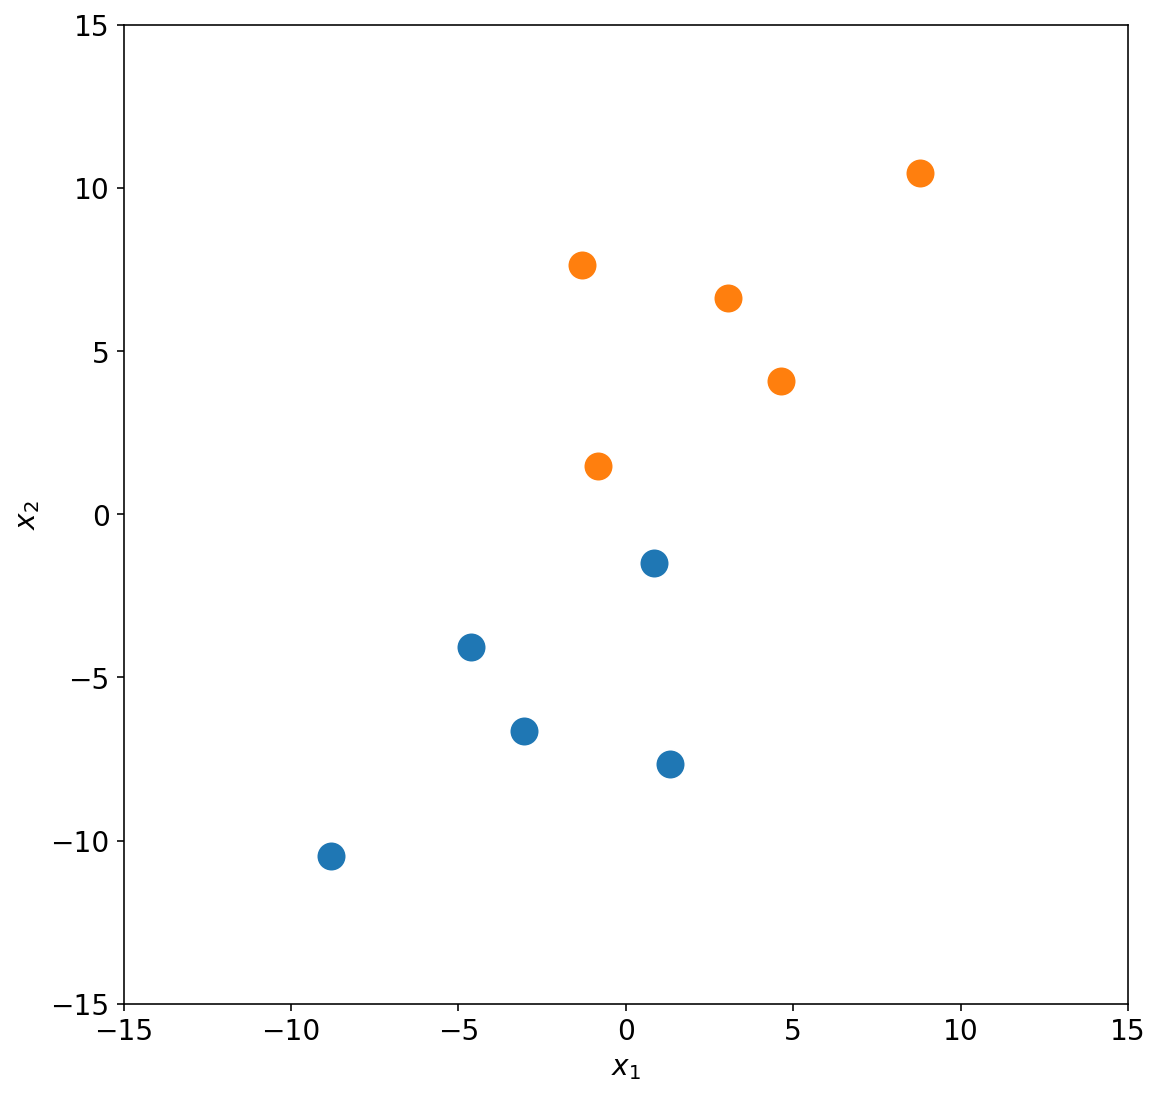

In [6]:
fig, ax = plt.subplots()
ax.plot(*X[:5].T, 'o')
ax.plot(*X[5:].T, "o")
ax.set(xlabel='$x_1$', ylabel='$x_2$')
ax.set_ylim([-15, 15])
ax.set_xlim([-15, 15])
plt.show()

# Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
model = LogisticRegression(penalty="none")

In [ ]:
model.fit(X, y)

In [ ]:
y_pred = logistic_over_grid(model.coef_, meshgrid)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
contour = ax.contourf(*meshgrid, y_pred[0], cmap=divergent_cmap, levels=9)
ax.plot(*X[:5].T, 'o')
ax.plot(*X[5:].T, "o")
cbar = plt.colorbar(contour, ax=ax)
ax.set(xlabel='$x_1$', ylabel='$x_2$')
cbar.ax.set_ylabel('Probability of $y=1$')
plt.show()

# Bayesian logistic regression

In [7]:
model = pystan.StanModel("./my_model.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_eebce64937b60d5594b9d2238e3ebfe1 NOW.


In [8]:
print(model.model_code)

data {
  int N;
  matrix[N, 2] X;
  int<lower=0, upper=1> y[N];
}

parameters {
  vector[2] w;
}

model {
  w ~ normal(0, 1);
  y ~ bernoulli_logit(X * w);
}


In [9]:
data = {
    "N": len(y),
    "X": X,
    "y": y,
}

In [10]:
samples = model.sampling(data)

In [11]:
samples

Inference for Stan model: anon_model_eebce64937b60d5594b9d2238e3ebfe1.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
w[1]   0.18    0.02   0.72  -1.17   -0.3   0.13   0.64   1.73   1385    1.0
w[2]    1.3    0.02   0.59   0.35   0.85   1.22   1.67   2.61   1366    1.0
lp__  -1.91    0.03   1.03  -4.69  -2.27  -1.61  -1.19  -0.95   1079    1.0

Samples were drawn using NUTS at Thu Sep 24 11:39:35 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [12]:
samples["w"]

array([[ 0.04612001,  0.82302662],
       [ 0.03472577,  2.08424413],
       [ 1.24620124,  1.07698411],
       ...,
       [-0.1567345 ,  1.09917561],
       [ 0.13802604,  0.95026686],
       [ 0.02157176,  0.86984926]])

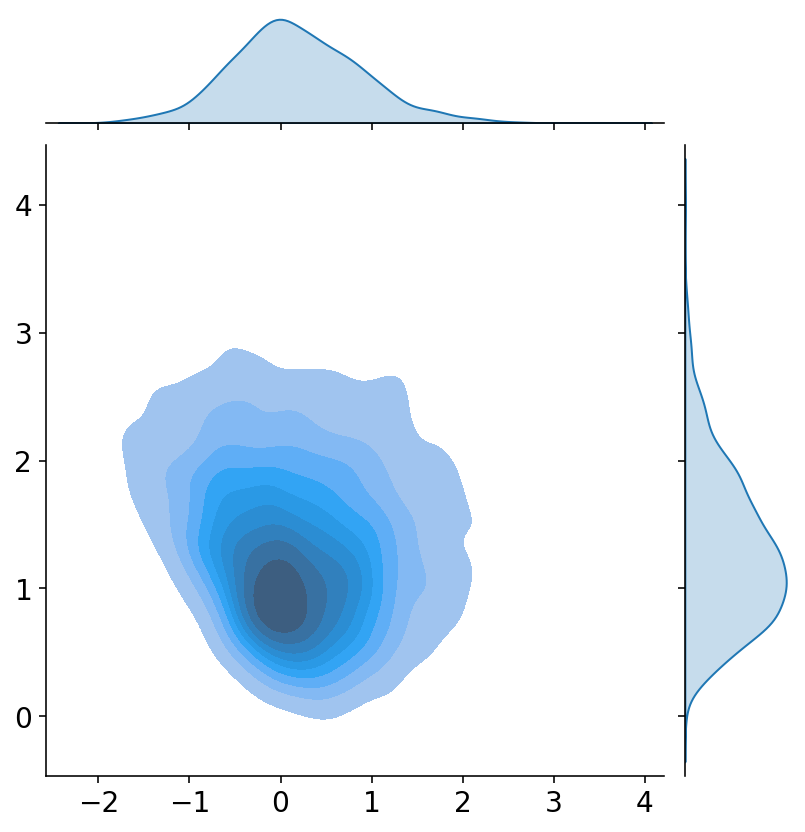

In [13]:
sns.jointplot(x=samples["w"][:,0], y=samples["w"][:, 1], kind='kde', fill=True)
plt.show()

In [14]:
# All the points on the X1-X2 plane for which we want to make predictions
x = np.linspace(-15, 15)
meshgrid = np.meshgrid(x, x)

# One sample at a time

In [15]:
import random

In [22]:
w = random.choice(samples["w"])
w

array([0.31566091, 1.54679244])

In [23]:
y_pred = logistic_over_grid(w, meshgrid)

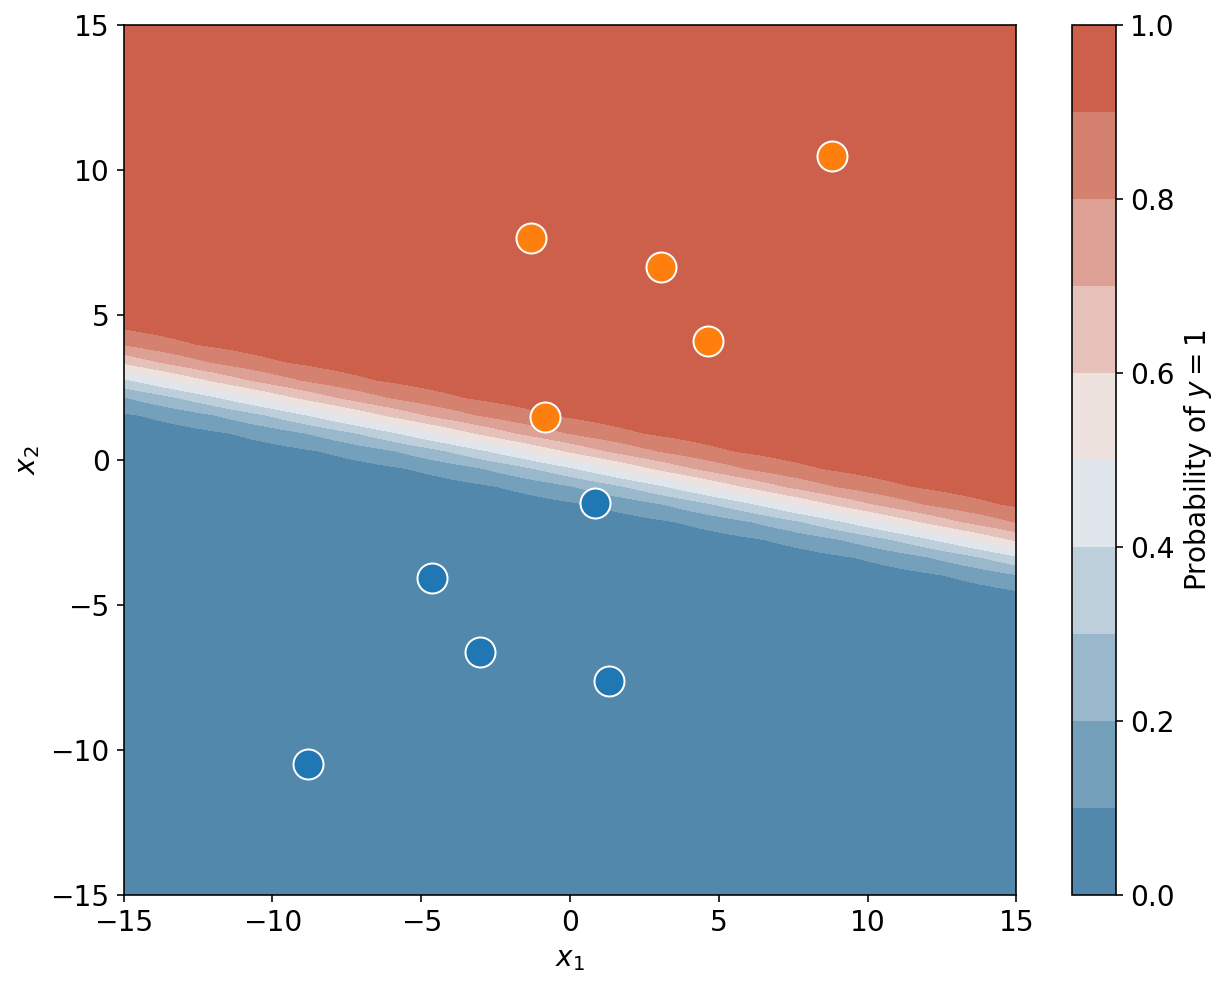

In [24]:
fig, ax = plt.subplots(figsize=(10, 8))
contour = ax.contourf(*meshgrid, y_pred, cmap=divergent_cmap, levels=9)
ax.plot(*X[:5].T, 'o')
ax.plot(*X[5:].T, "o")
cbar = plt.colorbar(contour, ax=ax)
ax.set(xlabel='$x_1$', ylabel='$x_2$')
cbar.ax.set_ylabel('Probability of $y=1$')
plt.show()

# All samples

In [ ]:
y_probas = logistic_over_grid(samples["w"], meshgrid)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
contour = ax.contourf(*meshgrid, y_probas.mean(axis=0), cmap=divergent_cmap, levels=100, vmin=0, vmax=1)
ax.plot(*X[:5].T, 'o')
ax.plot(*X[5:].T, "o")
cbar = plt.colorbar(contour, ax=ax)
ax.set(xlabel='$x_1$', ylabel='$x_2$')
cbar.ax.set_ylabel('Average probability of $y=1$')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
contour = ax.contourf(*meshgrid, y_probas.std(axis=0), cmap=helix_cmap, levels=100)
ax.plot(*X[:5].T, 'o')
ax.plot(*X[5:].T, "o")
cbar = plt.colorbar(contour, ax=ax)
# ax.set(xlabel='$x_1$', ylabel='$x_2$')
cbar.ax.set_ylabel('Posterior Std. Deviation')
plt.show()